In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install skfeature-chappers
import sys
import joblib
import warnings
warnings.filterwarnings("ignore")
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector


In [86]:
df = pd.read_csv("/content/drive/MyDrive/Major Project/Exoplanets/Data/cleaned_exoplanets_2018.csv")

In [87]:
df.drop('Exoplanet Archive Disposition', axis=1, inplace=True)

In [88]:
X = df.iloc[:,:-1].values
y = df.iloc[:, -1:].values

# **Quasi Constant**

In [89]:
from sklearn.feature_selection import VarianceThreshold
quasiConstant = VarianceThreshold(threshold=0.01) 
quasiConstant.fit(X)
quasiConstantColumns = [x for x in df.iloc[:,:-1].columns if x not in df.iloc[:,:-1].columns[quasiConstant.get_support()]]
quasiConstantColumns

['Orbital Period Upper',
 'Orbital Period Lower',
 'Transit Epoch Upper',
 'ransit Epoch Lower',
 'Stellar Surface Gravity Lower']

Drop Quasi constant columns with a threshold for 99% sample size

In [90]:

df.drop(quasiConstantColumns, axis = 1, inplace=True)
df.shape

(9564, 38)

In [91]:
X = df.iloc[:,:-1].values
y = df.iloc[:, -1:].values

# **Information Gain**

In [92]:
def plotFeatureImportance(df, importance, figsize=(15, 15), color='teal'):
    import matplotlib.pyplot as plt
    %matplotlib inline

    plt.figure(figsize=figsize)
    feat_importances = pd.Series(importances, df.columns[0:len(df.columns)-1])
    feat_importances.plot(kind = 'barh', color = color)
    plt.rc_context({'axes.edgecolor':'#581845', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'#F1D8DD'})
    plt.show()


Remove features with information gain below 0.025

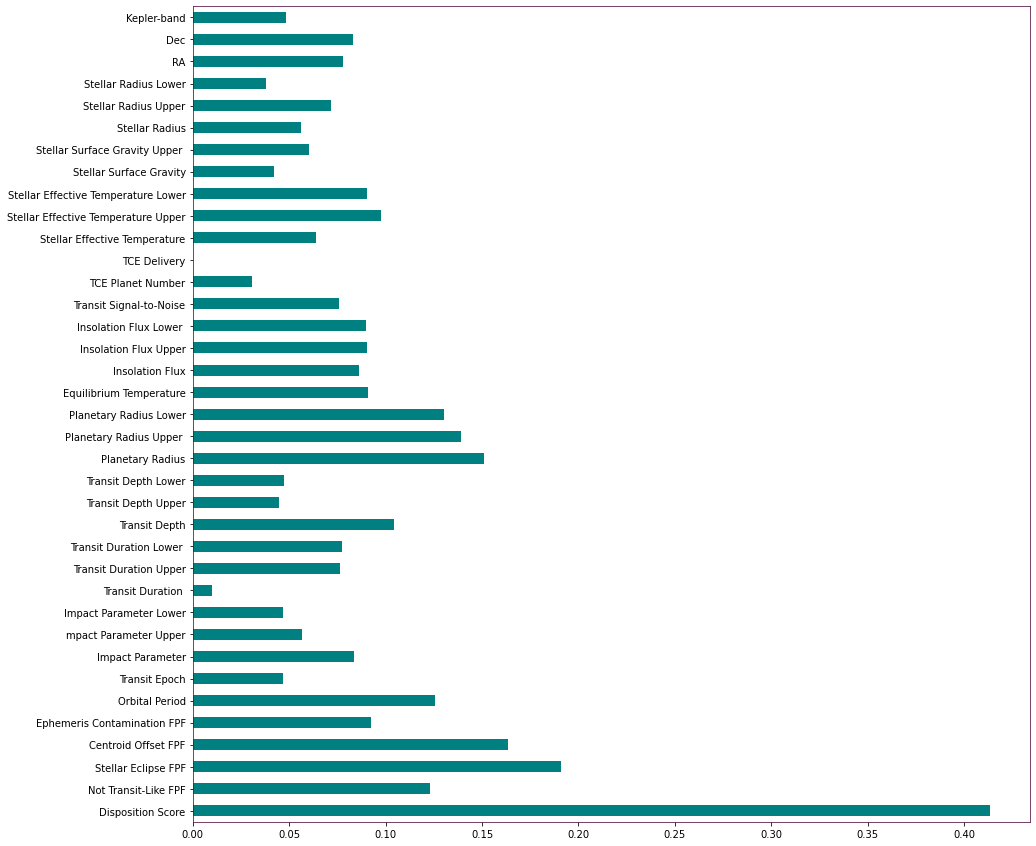

In [93]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)
plotFeatureImportance(df, importances)

In [94]:
df.drop('Transit Duration ', axis=1, inplace=True)

In [95]:
corrMatrix = df.iloc[:, :-1].corr()
corrMatrix

,Disposition Score,Not Transit-Like FPF,Stellar Eclipse FPF,Centroid Offset FPF,Ephemeris Contamination FPF,Orbital Period,Transit Epoch,Impact Parameter,mpact Parameter Upper,Impact Parameter Lower,...,Stellar Effective Temperature Upper,Stellar Effective Temperature Lower,Stellar Surface Gravity,Stellar Surface Gravity Upper,Stellar Radius,Stellar Radius Upper,Stellar Radius Lower,RA,Dec,Kepler-band
Disposition Score,1.000000,-0.005717,-0.532809,-0.487698,-0.384124,-0.012397,-0.000166,-0.045050,-0.118290,-0.033164,...,-0.340233,0.301335,0.128435,-0.149124,-0.066048,-0.093785,0.070457,-0.158145,0.086642,0.036483
Not Transit-Like FPF,-0.005717,1.000000,-0.023270,-0.004575,0.000576,0.001554,0.016143,0.002053,-0.002872,-0.002720,...,0.017044,-0.010672,-0.002137,-0.001038,0.000875,0.003087,-0.000671,0.012693,0.007914,-0.003754
Stellar Eclipse FPF,-0.532809,-0.023270,1.000000,0.151233,0.096539,-0.020557,-0.117435,0.038238,0.142043,0.045898,...,0.197206,-0.170443,-0.070550,0.115590,0.044500,0.044318,-0.045426,0.086374,-0.048116,0.000662
Centroid Offset FPF,-0.487698,-0.004575,0.151233,1.000000,0.523851,-0.020804,-0.123592,0.006618,0.110170,-0.001315,...,0.144524,-0.107650,-0.016497,-0.011768,0.037443,0.030379,-0.031052,0.159923,-0.097175,0.060582
Ephemeris Contamination FPF,-0.384124,0.000576,0.096539,0.523851,1.000000,-0.017021,-0.101114,-0.007406,0.032466,0.009126,...,0.108412,-0.074557,0.004309,-0.008645,0.016410,0.020582,-0.011594,0.070498,-0.045119,0.039068
Orbital Period,-0.012397,0.001554,-0.020557,-0.020804,-0.017021,1.000000,0.095580,0.005217,-0.001287,-0.003716,...,0.004957,0.003476,0.001518,-0.006673,-0.001087,-0.000389,0.001704,0.005670,0.011479,-0.009859
Transit Epoch,-0.000166,0.016143,-0.117435,-0.123592,-0.101114,0.095580,1.000000,0.051261,0.040190,-0.056421,...,0.035461,-0.023406,-0.011266,-0.033438,-0.005510,0.010454,0.010874,-0.029615,0.012702,0.010115
Impact Parameter,-0.045050,0.002053,0.038238,0.006618,-0.007406,0.005217,0.051261,1.000000,0.131224,-0.776598,...,0.029334,-0.041251,-0.056651,0.009460,0.022717,0.019923,-0.026999,0.019698,-0.005448,-0.010056
mpact Parameter Upper,-0.118290,-0.002872,0.142043,0.110170,0.032466,-0.001287,0.040190,0.131224,1.000000,-0.199062,...,0.045439,-0.034150,0.003713,0.007921,0.010430,0.006678,-0.008414,0.022416,-0.029541,0.046968
Impact Parameter Lower,-0.033164,-0.002720,0.045898,-0.001315,0.009126,-0.003716,-0.056421,-0.776598,-0.199062,1.000000,...,0.010302,0.006977,0.032204,0.020268,-0.014073,-0.003306,0.020048,0.004749,-0.005014,-0.001300


Remove features with correlation greater than 0.85

In [96]:
corrMatrix = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))
[column for column in corrMatrix.columns if any(corrMatrix[column] > 0.85)]

['Insolation Flux Upper']

In [97]:
df.drop('Insolation Flux Upper', axis = 1, inplace=True)

In [98]:
df.shape

(9564, 36)

In [101]:
def sequentialFeatureSelector(df, classifier, X, y):
    ffs = SequentialFeatureSelector(classifier,k_features='best',forward=True,n_jobs=1)
    ffs.fit(X, y)
    features = list(ffs.k_feature_names_)
    features = list(map(int, features))

    selectedColumns = []
    cols = list(df.columns)
    print(features)
    for index in features:
        if index > 34:
            continue
        selectedColumns.append(cols[index])
    selectedColumns.append('Disposition Using Kepler Data')
    print(selectedColumns)
    return df[selectedColumns]

In [102]:
from sklearn.linear_model import LogisticRegression
lrClassifier = LogisticRegression()
df_LR = sequentialFeatureSelector(df, lrClassifier, X, y)

[0, 1, 2, 3, 4, 13, 20, 30, 35]
['Disposition Score', 'Not Transit-Like FPF', 'Stellar Eclipse FPF', 'Centroid Offset FPF', 'Ephemeris Contamination FPF', 'Transit Depth Upper', 'Insolation Flux Lower ', 'Stellar Radius Upper', 'Disposition Using Kepler Data']


In [103]:
from sklearn.naive_bayes import GaussianNB
NBClassifier = GaussianNB()
df_NB = sequentialFeatureSelector(df, NBClassifier, X, y)

[0, 1, 2, 3, 4, 5, 7, 10, 11, 17, 19, 23, 24, 26, 27, 28, 29, 31, 34, 35, 36]
['Disposition Score', 'Not Transit-Like FPF', 'Stellar Eclipse FPF', 'Centroid Offset FPF', 'Ephemeris Contamination FPF', 'Orbital Period', 'Impact Parameter', 'Transit Duration Upper', 'Transit Duration Lower ', 'Planetary Radius Lower', 'Insolation Flux', 'TCE Delivery', 'Stellar Effective Temperature', 'Stellar Effective Temperature Lower', 'Stellar Surface Gravity', 'Stellar Surface Gravity Upper ', 'Stellar Radius', 'Stellar Radius Lower', 'Kepler-band', 'Disposition Using Kepler Data']


In [104]:
from sklearn.ensemble import RandomForestClassifier
RFClassifier = RandomForestClassifier(n_estimators = 50, criterion = 'entropy',random_state = 41)
df_RF = sequentialFeatureSelector(df, RFClassifier, X, y)

[0, 1, 2, 3, 4, 5, 10, 12, 24, 27, 28, 30]
['Disposition Score', 'Not Transit-Like FPF', 'Stellar Eclipse FPF', 'Centroid Offset FPF', 'Ephemeris Contamination FPF', 'Orbital Period', 'Transit Duration Upper', 'Transit Depth', 'Stellar Effective Temperature', 'Stellar Surface Gravity', 'Stellar Surface Gravity Upper ', 'Stellar Radius Upper', 'Disposition Using Kepler Data']


In [105]:
from sklearn.tree import DecisionTreeClassifier
DTClassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 41)
df_DT = sequentialFeatureSelector(df, DTClassifier, X, y)

[0, 1, 2, 3, 4, 7, 8, 9, 10, 13, 17, 18, 20, 22, 24, 25, 29, 36]
['Disposition Score', 'Not Transit-Like FPF', 'Stellar Eclipse FPF', 'Centroid Offset FPF', 'Ephemeris Contamination FPF', 'Impact Parameter', 'mpact Parameter Upper', 'Impact Parameter Lower', 'Transit Duration Upper', 'Transit Depth Upper', 'Planetary Radius Lower', 'Equilibrium Temperature', 'Insolation Flux Lower ', 'TCE Planet Number', 'Stellar Effective Temperature', 'Stellar Effective Temperature Upper', 'Stellar Radius', 'Disposition Using Kepler Data']


In [115]:
df_LR.to_csv('/content/drive/MyDrive/Major Project/Exoplanets/Data/LR_Data.csv', index=False)
df_NB.to_csv('/content/drive/MyDrive/Major Project/Exoplanets/Data/NB_Data.csv', index=False)
df_RF.to_csv('/content/drive/MyDrive/Major Project/Exoplanets/Data/RF_Data.csv', index=False)
df_DT.to_csv('/content/drive/MyDrive/Major Project/Exoplanets/Data/DT_Data.csv', index=False)